In [1]:
import os
from pathlib import Path
import re
import datetime
import tarfile
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

import torchNDF
from torchNDF.data.pandas_utils import *

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## In this notebook:

* Read and filter `DTCC` data: `log_return > 0`
* Alignment of `ndf` spot rates and `oanda` context spot rates
* Label distribution plots
* Distillation into hourly data (instead of daily)

In [2]:
PATH = Path('../../data/final').resolve()
df = pd.read_pickle(f'{PATH}/dtcc')

In [3]:
df[df['TERM_LENGTH']==10].head(1)

,EXECUTION_TIMESTAMP,PRICE_AFFECTING_TERM,OFF_FACILITY_SWAPS,EFFECTIVE_DATE,END_DATE,PLUS_USD,PLUS_CCY,CURRENCY,USD_AMOUNT,CCY_AMOUNT,NDF_RATE,SPOT_RATE,TERM_LENGTH,EXECUTION_TIMESTAMP_TIME,EXECUTION_TIMESTAMP_DATE,LOGRET
DISSEMINATION_ID,,,,,,,,,,,,,,,,
74506622,2017-11-17 10:54:39,N,Y,2017-11-17,2017-11-27,False,False,MYR,10.0,35.0,3.5,4.1106,10.0,10:54:39,2017-11-17,0.160806


In [4]:
df['LOGRET'].describe()
filtered_df = df[df['LOGRET'] > 0]

## Aligning with other datasets

In [36]:
PATH = Path('../../data/final').resolve()
ndf = pd.read_csv('{}/ndf_spots.csv'.format(PATH), index_col='Date')
oanda = pd.read_pickle(f'{PATH}/oanda_spots')
ndf.index = pd.to_datetime(ndf.index)
oanda.index = pd.to_datetime(oanda.index)

In [37]:
# check alignment of data slices for ndf and oanda data
ndf.index[0], ndf.index[-1], oanda.index[0], oanda.index[-1]

(Timestamp('2013-01-18 00:00:00'),
 Timestamp('2019-06-18 00:00:00'),
 Timestamp('2009-01-02 06:00:00+0000', tz='UTC'),
 Timestamp('2019-06-26 06:00:00+0000', tz='UTC'))

In [38]:
# normalize to midnight 
ndf.index = pd.to_datetime(ndf.index).date 
oanda.index = pd.to_datetime(oanda.index).date;
ndf.index = pd.to_datetime(ndf.index)
oanda.index = pd.to_datetime(oanda.index)

oanda = oanda[~oanda.index.duplicated()]
ndf = ndf[~ndf.index.duplicated()]
# remove older data for dates not present in `ndf` spots
oanda = oanda[oanda.index.isin(ndf.index)]
# remove rows with missing index in `oanda`
ndf = ndf[ndf.index.isin(oanda.index)]

In [39]:
len(ndf), len(oanda)

(1653, 1653)

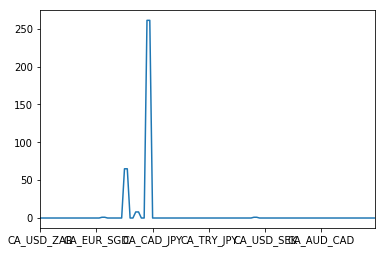

In [47]:
oanda.isna().sum().plot()
# fix few NaNs by ffilling
oanda.fillna(method='ffill', inplace=True)

In [49]:
# get CA+CB/2 feature
cols = oanda.columns
for i in range(len(cols)//2):
    oanda[cols[2*i]] = (oanda[cols[2*i]] + oanda[cols[2*i+1]])/2
# drop previous features
for i in range(len(cols)//2):
    oanda.drop(columns=cols[2*i+1], inplace=True)

In [50]:
# get instrument names
for col in oanda.columns:
    new_name = ''.join(col.split('_')[1:3])
    oanda.rename(columns={col: new_name}, inplace=True)

In [51]:
all_currencies = pd.concat([ndf, oanda], axis=1, sort=False) 

In [52]:
# sanity check
all_currencies.head(10)

,USDKRW,USDTWD,USDMYR,USDIDR,USDPHP,USDCNY,USDCNH,USDINR,USDZAR,CHFZAR,...,AUDCAD,GBPCAD,USDDKK,CADSGD,EURCAD,USDNOK,EURPLN,NZDSGD,AUDSGD,NZDJPY
2013-01-18,1059.000,28.9100,3.01525,9842.0,40.520,6.27425,6.19050,54.090,8.859240,9.453460,...,1.038555,1.577090,5.575930,1.241440,1.321215,5.57175,4.11839,1.024355,1.289305,75.346001
2013-01-21,1064.960,28.9525,3.03715,9819.5,40.665,6.27750,6.19350,54.090,8.888639,9.515526,...,1.042340,1.574095,5.603760,1.240045,1.321000,5.60502,4.15564,1.027590,1.292535,74.842499
2013-01-22,1064.375,28.9550,3.04415,9755.0,40.565,6.27600,6.19700,53.805,8.845440,9.508410,...,1.046345,1.572360,5.585720,1.236675,1.324745,5.58254,4.16584,1.031575,1.293995,75.106506
2013-01-23,1067.800,28.9675,3.04815,9761.5,40.580,6.27650,6.20450,53.970,8.881150,9.554405,...,1.046450,1.571360,5.610860,1.236675,1.320465,5.58429,4.17261,1.032655,1.294185,74.140999
2013-01-24,1070.350,29.0250,3.04815,9784.0,40.630,6.27900,6.20735,53.965,9.033850,9.712355,...,1.052485,1.584150,5.593130,1.227440,1.334265,5.55363,4.16961,1.033720,1.291750,75.207504
2013-01-25,1076.100,29.1475,3.05365,9800.0,40.665,6.28350,6.21300,54.030,9.046880,9.729500,...,1.049205,1.581920,5.575860,1.226745,1.342465,5.53121,4.18614,1.029850,1.287040,75.766998
2013-01-28,1094.715,29.4380,3.06525,9848.5,40.735,6.28950,6.22350,54.105,8.969709,9.660845,...,1.051315,1.588940,5.550085,1.227330,1.355745,5.53326,4.17020,1.034720,1.290300,75.923500
2013-01-29,1086.995,29.5250,3.08445,9819.5,40.725,6.29200,6.22200,53.910,9.098909,9.824980,...,1.051080,1.580470,5.549700,1.228025,1.353145,5.53841,4.19525,1.033370,1.290730,75.856003
2013-01-30,1085.350,29.4775,3.08605,9811.0,40.605,6.28425,6.21450,53.625,9.040190,9.806790,...,1.049110,1.578495,5.529580,1.233005,1.351820,5.49816,4.18904,1.033175,1.293420,76.033997
2013-01-31,1090.045,29.5430,3.11095,9814.0,40.685,6.28625,6.21350,53.500,9.053270,9.942150,...,1.042705,1.585805,5.502640,1.234605,1.360500,5.47805,4.20764,1.034360,1.287180,75.862000


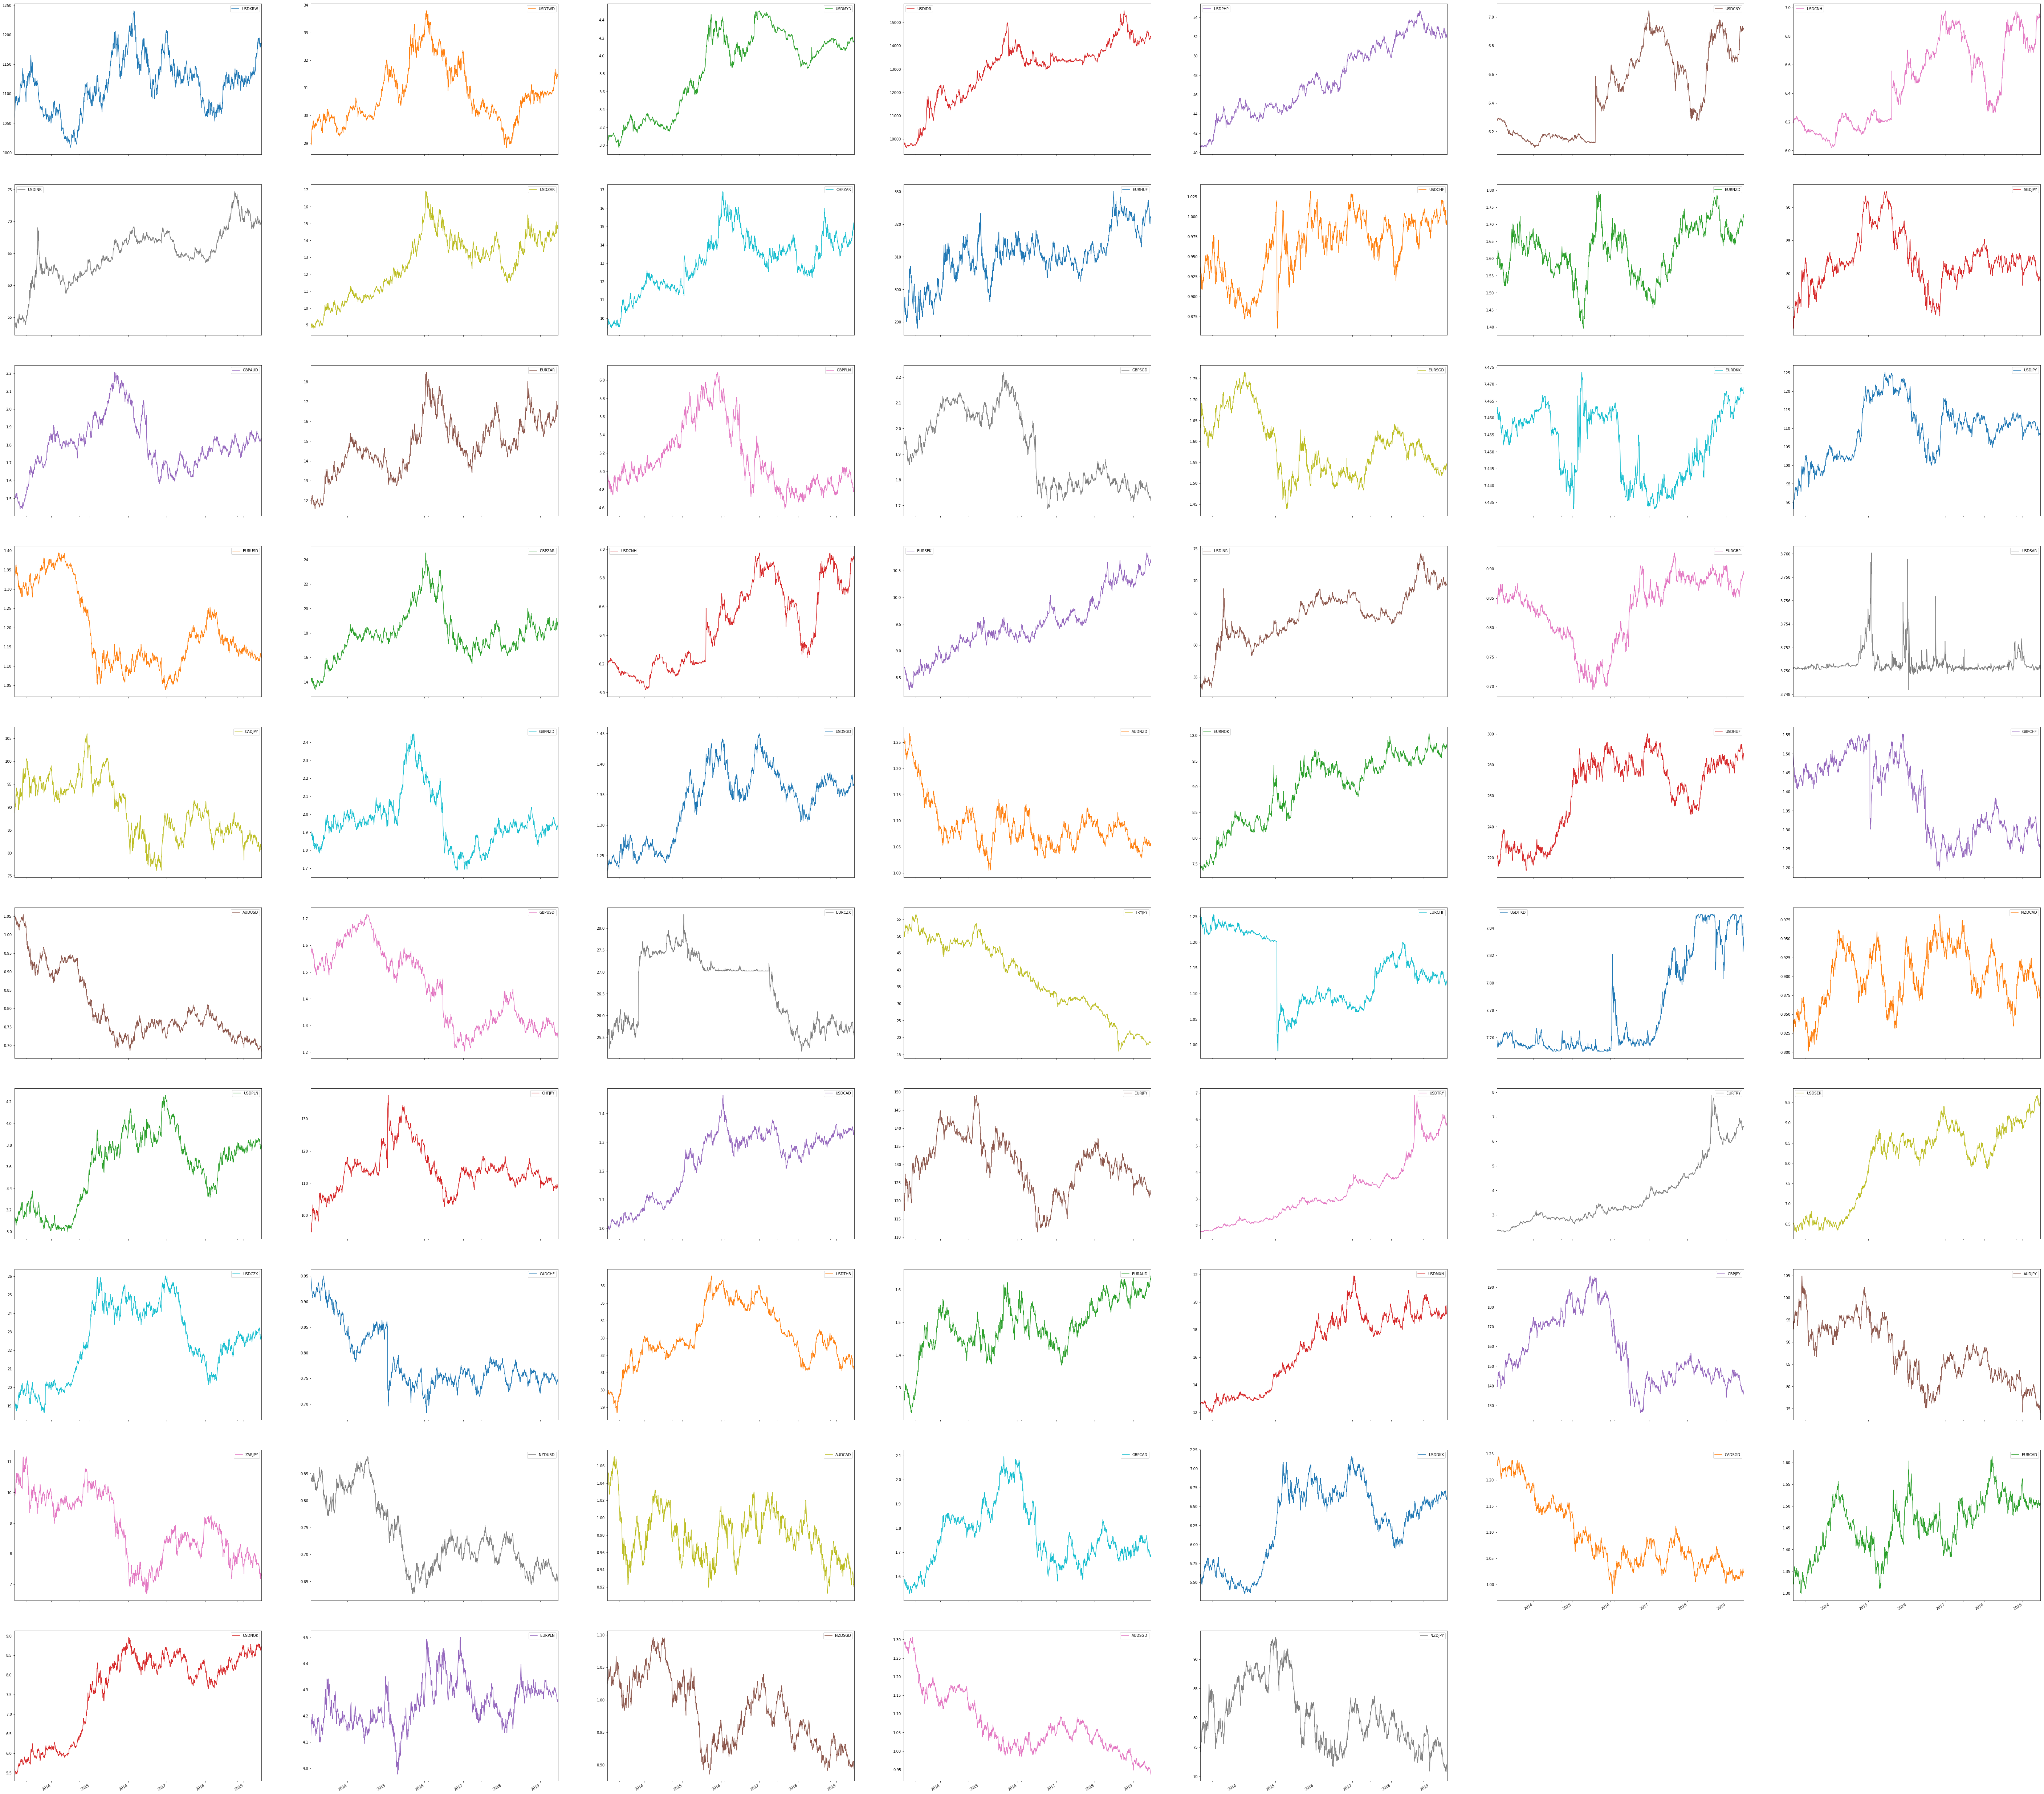

In [53]:
all_currencies.plot(subplots=True, figsize=(100,100),layout=(10, 7));

In [54]:
import os
PATH = os.path.realpath('../../data/final')
all_currencies.to_pickle(f'{PATH}/ndf_oanda_spots')

## Knowledge distillation: volume features from `DTCC`

In [16]:
max(df['TERM_LENGTH'])

90.0

In [19]:
# uncomment to obtain filtered volume dtcc data
# df = filtered_df

df.groupby(['CURRENCY'])['LOGRET'].describe()

,count,mean,std,min,25%,50%,75%,max
CURRENCY,,,,,,,,
CNY,206329.0,0.010018,0.011814,2.220446e-16,0.002249,0.005647,0.013033,0.158560
IDR,403586.0,0.018955,0.018030,4.995115e-12,0.005698,0.014285,0.026670,0.388692
INR,1521603.0,0.014399,0.014922,3.318401e-09,0.004830,0.010067,0.019112,0.283133
KRW,1057622.0,0.016929,0.013976,4.058087e-11,0.005664,0.013433,0.024804,0.210423
MYR,354043.0,0.025379,0.023690,2.220446e-16,0.008028,0.018690,0.035865,0.634305
PHP,314029.0,0.012615,0.010697,1.329946e-09,0.004504,0.009823,0.017588,0.293775
TWD,513941.0,0.009993,0.009282,4.440892e-16,0.003151,0.007161,0.014371,0.095524


In [20]:
points = len(df) - df['EFFECTIVE_DATE'][df['EFFECTIVE_DATE'].isin(all_currencies.index)].count()
f'There are {points} entries in DTCC without a corresponding entry (in terms of date) in the merged FX spot data, or {round(100*points/len(df),2)}% of \
the entire DTCC dataset (filtered by tenor length)'

'There are 13521 entries in DTCC without a corresponding entry (in terms of date) in the merged FX spot data, or 0.31% of the entire DTCC dataset (filtered by tenor length)'

In [21]:
to_distill = df[df['EFFECTIVE_DATE'].isin(all_currencies.index)]

In [22]:
from textwrap import wrap
columns = all_currencies.columns[:8]
[wrap(element, 3)[1] for element in columns]

['KRW', 'TWD', 'MYR', 'IDR', 'PHP', 'CNY', 'CNH', 'INR']

In [23]:
# remove the 'USD' from all strings
currencies = [wrap(element, 3)[1] for element in columns]
renaming_dict = dict(zip(currencies, columns))
# use full name (e.g `USDKRW`) instad of `KRW`, since all settlement currencies
# have been filtered: USD
to_distill['CURRENCY'].replace(renaming_dict, inplace=True)
to_distill.loc[:,'PCT_CHANGE'] = (to_distill['SPOT_RATE'] - to_distill['NDF_RATE'])/to_distill['NDF_RATE']
to_distill.loc[:,'BASIS_CHANGE'] = 100*to_distill['PCT_CHANGE']

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:6788: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [24]:
to_distill_narrow = to_distill[['EFFECTIVE_DATE', 'TERM_LENGTH', 'USD_AMOUNT', 'CURRENCY', 'BASIS_CHANGE', 'LOGRET']]

In [25]:
to_distill_narrow.head()

,EFFECTIVE_DATE,TERM_LENGTH,USD_AMOUNT,CURRENCY,BASIS_CHANGE,LOGRET
DISSEMINATION_ID,,,,,,
36795980,2015-10-27,44.0,44000.0,USDMYR,88.571113,0.634305
36795981,2015-10-27,44.0,44000.0,USDMYR,88.571113,0.634305
32298688,2015-07-21,73.0,5.0,USDIDR,47.504950,0.388692
32297867,2015-07-21,73.0,5.0,USDIDR,47.504950,0.388692
32298634,2015-07-21,71.0,5.0,USDIDR,46.980198,0.385128


In [27]:
diff_degree = 1
# basis point change
state = all_currencies.pct_change(diff_degree).dropna()

In [28]:
# new features: expert positive trades with term length specified after `_`
for term in range(1, 91):
    new_features = [n + f'_{term}' for n in columns]
    new_features_ret = [n + f'_{term}_logret' for n in columns]
    for i in range(8):
        state.loc[:, new_features[i]] = 0
        state.loc[:, new_features_ret[i]] = 0

In [ ]:
from tqdm import tqdm_notebook as tqdm
for _, row in tqdm(to_distill_narrow.iterrows()):
    if row['EFFECTIVE_DATE'].date() in state.index:
        term = int(row['TERM_LENGTH'])
        curr = row['CURRENCY']
        state.loc[row['EFFECTIVE_DATE'].date(), f'{curr}_{term}'] += row['USD_AMOUNT']
        state.loc[row['EFFECTIVE_DATE'].date(), f'{curr}_{term}_logret'] = row['LOGRET']

In [33]:
state.head(100)

,USDKRW,USDTWD,USDMYR,USDIDR,USDPHP,USDCNY,USDCNH,USDINR,USDZAR,CHFZAR,...,USDIDR_90,USDIDR_90_logret,USDPHP_90,USDPHP_90_logret,USDCNY_90,USDCNY_90_logret,USDCNH_90,USDCNH_90_logret,USDINR_90,USDINR_90_logret
2013-01-21,0.005628,0.001470,0.007263,-0.002286,0.003578,0.000518,0.000485,0.000000,0.003319,0.006565,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,0,0.0,0.000000
2013-01-22,-0.000549,0.000086,0.002305,-0.006569,-0.002459,-0.000239,0.000565,-0.005269,-0.004860,-0.000748,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,0,0.0,0.000000
2013-01-23,0.003218,0.000432,0.001314,0.000666,0.000370,0.000080,0.001210,0.003067,0.004037,0.004837,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,0,0.0,0.000000
2013-01-24,0.002388,0.001985,0.000000,0.002305,0.001232,0.000398,0.000459,-0.000093,0.017194,0.016532,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,0,0.0,0.000000
2013-01-25,0.005372,0.004220,0.001804,0.001635,0.000861,0.000717,0.000910,0.001204,0.001442,0.001765,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,0,0.0,0.000000
2013-01-28,0.017299,0.009967,0.003799,0.004949,0.001721,0.000955,0.001690,0.001388,-0.008530,-0.007056,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,0,0.0,0.000000
2013-01-29,-0.007052,0.002955,0.006264,-0.002945,-0.000245,0.000397,-0.000241,-0.003604,0.014404,0.016990,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,0,0.0,0.000000
2013-01-30,-0.001513,-0.001609,0.000519,-0.000866,-0.002947,-0.001232,-0.001205,-0.005287,-0.006453,-0.001851,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,0,0.0,0.000000
2013-01-31,0.004326,0.002222,0.008069,0.000306,0.001970,0.000318,-0.000161,-0.002331,0.001447,0.013803,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,0,0.0,0.000000
2013-02-01,0.005601,0.002996,0.000000,-0.006929,-0.000123,0.000437,-0.000153,0.001869,-0.010411,-0.009361,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,0,0.0,0.000000


In [32]:
len(state)

1652

In [35]:
PATH = Path('../../data/final/').resolve()
pd.to_pickle(state, f'{PATH}/all_volumes')

We obtained a dataset with volume information for different tenors:

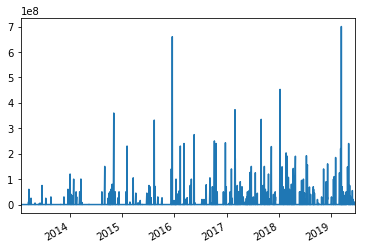

In [34]:
state['USDKRW_1'].plot()

## PnL by currency and tenor

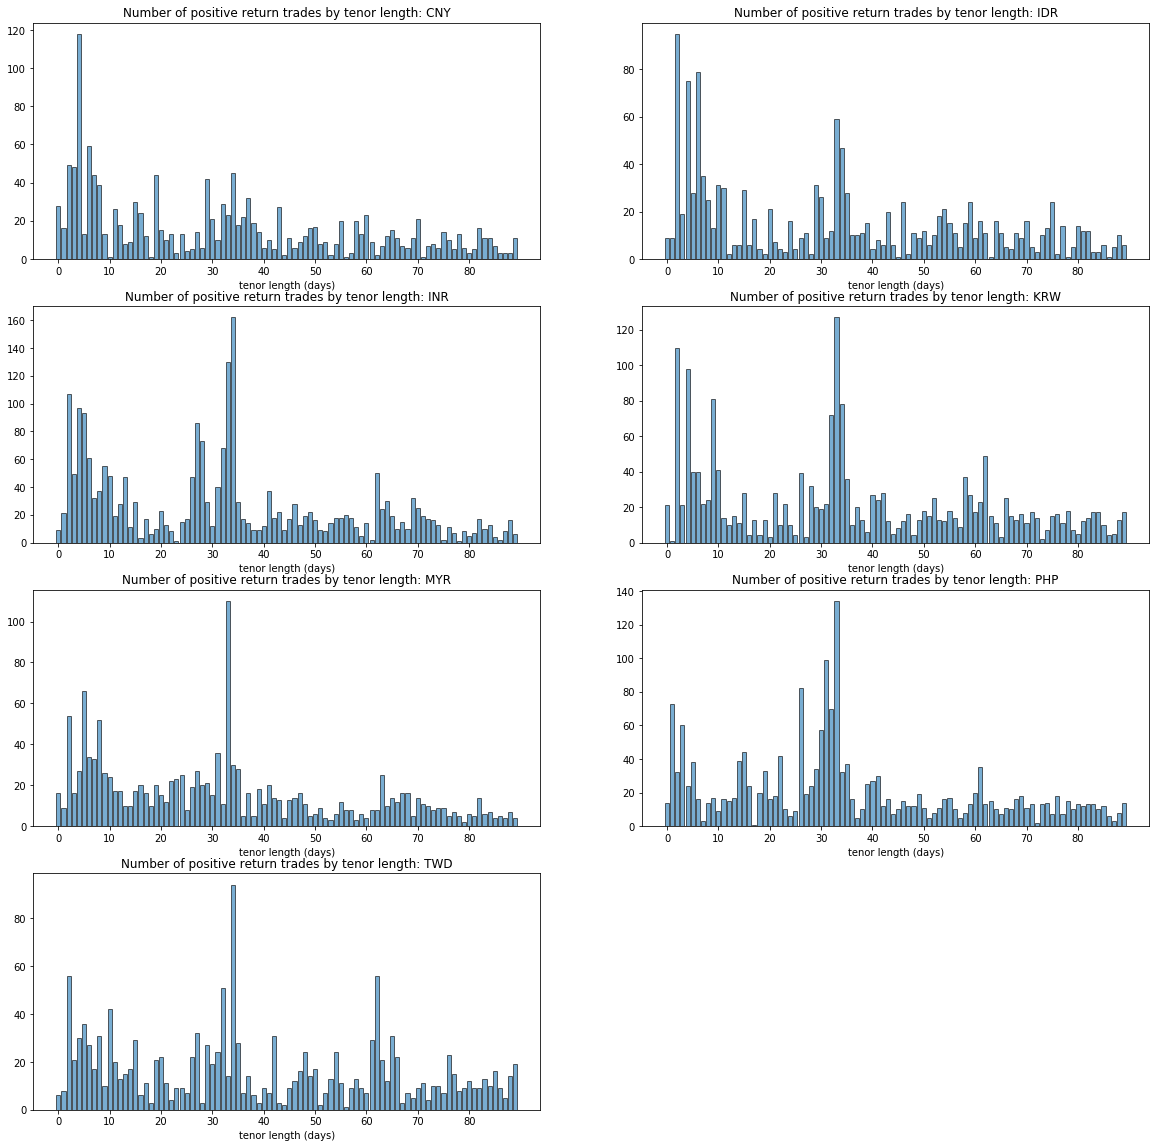

In [288]:
import natsort
# get rid of quantized spots (first 68 columns)
plotting_data = state.iloc[:, 68:]
# reindex so that the columns -> `USDKRW_1, USDKRW_2 ... instead of USDKRW_1, USD_CNH_1 ...`
plotting_data = plotting_data.reindex(columns=natsort.natsorted(plotting_data.columns))
# drop CNH (no vol recorded in DTCC)
plotting_data = plotting_data.iloc[:, 90:] 
plotting_data = (plotting_data > 0).astype(int)
plotting_data.index = pd.to_datetime(plotting_data.index)

plt.figure(figsize=(20,20))
currs = ['CNY', 'IDR', 'INR', 'KRW', 'MYR', 'PHP', 'TWD']
for i in range(7):
    plt.subplot(421+i)
    curr_vol_by_tenor = plotting_data.iloc[:, i*90: (i+1)*90]
    plt.bar(np.arange(0, 90, 1), curr_vol_by_tenor[curr_vol_by_tenor==1].count(), alpha=0.6, edgecolor='black')
    plt.xticks(np.arange(0, 90, 10))
    plt.title(f'Number of positive return trades by tenor length: {currs[i]}')
    plt.xlabel('tenor length (days)')
    plt.savefig('posret_tenor_curr.jpg')

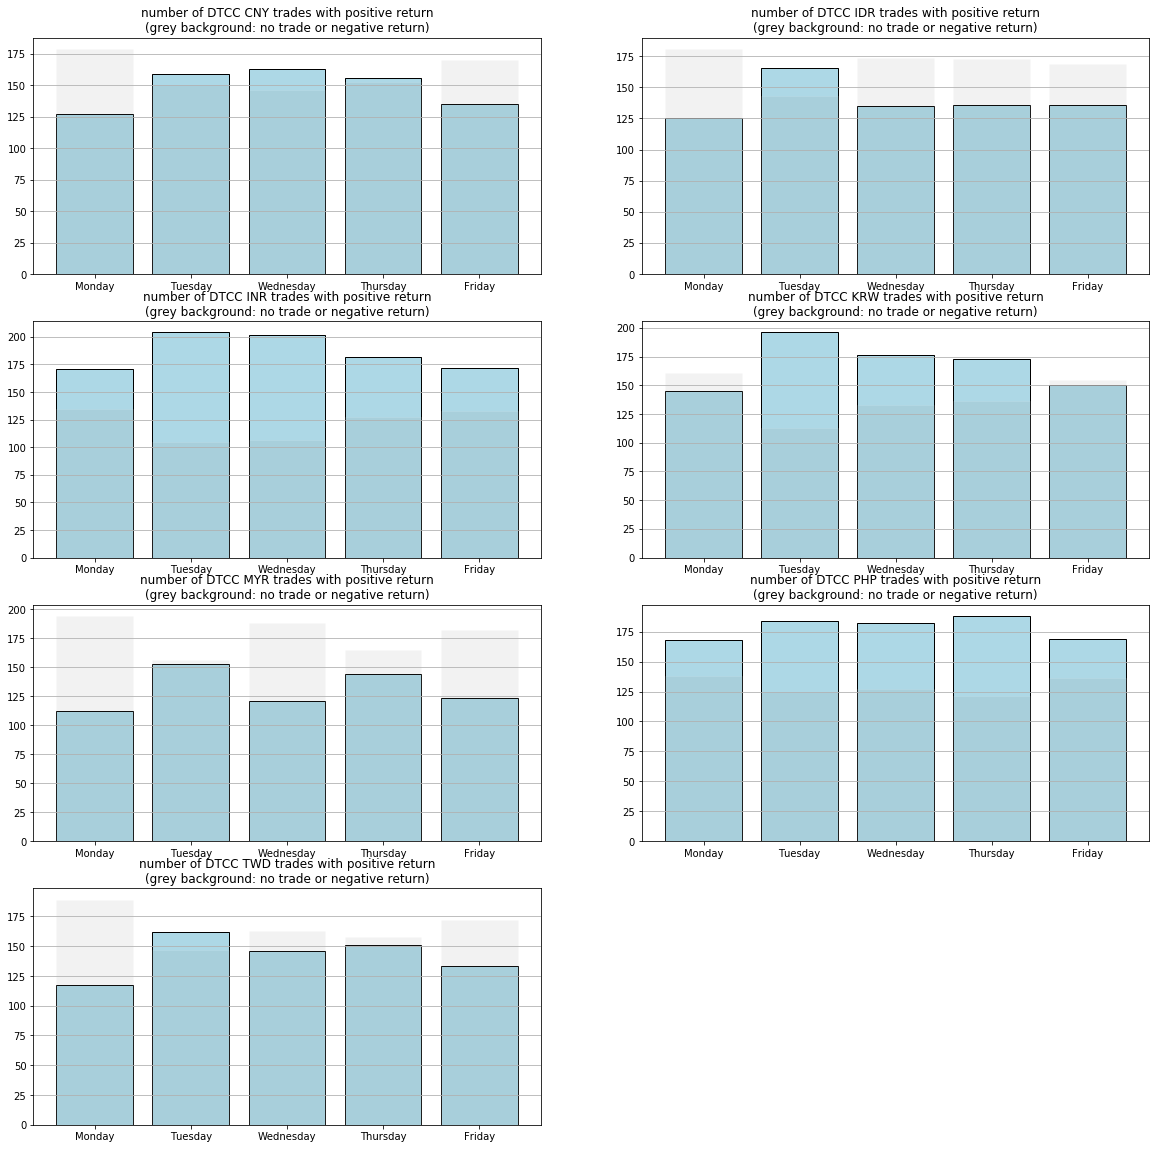

In [294]:
for curr in range(0, 7):
    plotting_data.iloc[:,curr*90] = plotting_data.iloc[:,curr*90:(curr+1)*90].sum(axis=1)
# grab first col of each curr where vol has been aggregated
plotting_data =  plotting_data.iloc[:, np.arange(0, 630, 90)]
# bool feat
plotting_data = (plotting_data > 0).astype(int)

plt.figure(figsize=(20,20))

for i in range(7):
    plt.subplot(421+i)
    data = plotting_data.iloc[:, i]
    plt.bar(np.linspace(0, 4, 5), data[data==1].index.weekday.value_counts(sort=False).values, 
            color='lightblue', edgecolor='black')
    plt.bar(np.linspace(0, 4, 5), data[data==0].index.weekday.value_counts(sort=False).values, 
            color='grey', edgecolor='white', alpha=0.1)
    plt.grid(axis='y')
    plt.xticks(ticks=[0,1,2,3,4], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    plt.title(f'number of DTCC {currs[i]} trades with positive return\n' +
              '(grey background: no trade or negative return)')
    plt.savefig('day_all_currencies.jpg')

## Appendix: distilling into `hourly` instead of `daily` data

In [ ]:
PATH = Path('../../data/sorted_filtered_dtcc').resolve()
d = pd.read_pickle(f'{PATH}/eight_currencies_cleaned')

# sort by timestamp, first value 
d.sort_values(by=['EXECUTION_TIMESTAMP'], inplace=True)

# keep rows where document signing date is same as effective date
d = d[d['EXECUTION_TIMESTAMP'].dt.date==d['EFFECTIVE_DATE'].dt.date]

# introduce `effective_hour` column
d['EFFECTIVE_HOUR'] = d['EXECUTION_TIMESTAMP'].dt.hour

# second element since first contains irregular date, last non NaT date
start = d.iloc[0]['EXECUTION_TIMESTAMP']
end = d.iloc[-1]['EXECUTION_TIMESTAMP']

# create full hourly range between start and end
complete_range = pd.date_range(start, end, freq='H')
date_index, hour_index = complete_range.date, complete_range.hour

# clean df to augment with volume info
df_to_augment = pd.DataFrame(data={'EXECUTION_DATE':date_index, 
                                   'EXECUTION_HOUR':hour_index}
                            )

# remove the 'USD' from all strings in ndf spot rate dataframe
currencies = [wrap(element, 3)[1] for element in columns]
renaming_dict = dict(zip(currencies, columns))

# use full name (e.g `USDKRW`) instad of `KRW`, since all settlement currencies
# have been filtered: USD
d.loc[:,'CURRENCY'].replace(renaming_dict, inplace=True)
d.loc[:,'PCT_CHANGE'] = (d['SPOT_RATE'] - d['NDF_RATE'])/d['NDF_RATE']
d.loc[:,'BASIS_CHANGE'] = 100*d['PCT_CHANGE']

# new features: expert positive trades with term length specified after `_`
for term in range(1, 91):
    new_features = [n + f'_{term}' for n in columns]
    for i in range(8):
        df_to_augment.loc[:, new_features[i]] = 0

        
from tqdm import tqdm_notebook as tqdm
for _, row in tqdm(d.iterrows()):
    date = row['EFFECTIVE_DATE'].date()
    hour = row['EFFECTIVE_HOUR']
    term = int(row['TERM_LENGTH'])
    curr = row['CURRENCY']
    usd_amount = row['USD_AMOUNT']
    if (sum(date == df_to_augment['EXECUTION_DATE']) > 0) and \
       (sum(hour == df_to_augment['EXECUTION_HOUR']) > 0):  
            mask = (df_to_augment['EXECUTION_DATE'] == date) & \
                   (df_to_augment['EXECUTION_HOUR'] == row['EFFECTIVE_HOUR'])
            df_to_augment.loc[mask, f'{curr}_{term}'] += usd_amount  

In [533]:
df_to_augment.head(20)

,EXECUTION_DATE,EXECUTION_HOUR,USDKRW_1,USDTWD_1,USDMYR_1,USDIDR_1,USDPHP_1,USDCNY_1,USDCNH_1,USDINR_1,...,USDCNH_89,USDINR_89,USDKRW_90,USDTWD_90,USDMYR_90,USDIDR_90,USDPHP_90,USDCNY_90,USDCNH_90,USDINR_90
0,2012-12-03,6,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,2012-12-03,7,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2,2012-12-03,8,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,2012-12-03,9,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,2012-12-03,10,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
5,2012-12-03,11,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
6,2012-12-03,12,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
7,2012-12-03,13,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
8,2012-12-03,14,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
9,2012-12-03,15,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


In [534]:
PATH = Path('../../data/sorted_filtered_dtcc').resolve()
pd.to_pickle(df_to_augment, f'{PATH}/volume_tenor_hourly')